# PeerRead Dataset EDA and Preparation
This notebook explores the PeerRead dataset and prepares it for fine-tuning the Qwen model using Unsloth.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from glob import glob
import json
import random
from sklearn.model_selection import train_test_split

# Set plot style
sns.set_theme(style="whitegrid")

## 1. Data Loading
Load parsed PDFs and review JSON files.

In [22]:
# Find all JSON files
parsed_pdfs = glob("PeerRead/data/**/parsed_pdfs/*.json", recursive=True)
reviews = glob("PeerRead/data/**/reviews/*.json", recursive=True)

print(f"Found {len(parsed_pdfs)} parsed PDFs and {len(reviews)} review files.")

def create_dataframe(file_list, key):
    records = []
    for file_path in file_list:
        with open(file_path, 'r') as f:
            data = json.load(f)
        records.append(data)
    return pd.DataFrame(records)

# Create DataFrames
parsed_pdfs_df = create_dataframe(parsed_pdfs, 'parsed_pdf')
reviews_df = create_dataframe(reviews, 'review')

print(f"Parsed PDFs DataFrame shape: {parsed_pdfs_df.shape}")
print(f"Reviews DataFrame shape: {reviews_df.shape}")

Found 12364 parsed PDFs and 12364 review files.
Parsed PDFs DataFrame shape: (12364, 2)
Reviews DataFrame shape: (12364, 12)


## 2. Data Preprocessing
Extract text and scores, merge datasets, and clean missing values.

In [23]:
def extract_text(metadata):
    if metadata and 'sections' in metadata and metadata['sections']:
        # Include headings to better match raw PDF extraction (like fitz)
        text_parts = []
        for section in metadata['sections']:
            if 'heading' in section and section['heading']:
                text_parts.append(section['heading'])
            if 'text' in section and section['text']:
                text_parts.append(section['text'])
        return "\n\n".join(text_parts)
    return ""

def extract_score(review_dict):
    if isinstance(review_dict, dict):
        # Try to get RECOMMENDATION
        score = review_dict.get('RECOMMENDATION')
        if score is not None:
            return float(score)
    return None

# Prepare parsed_pdfs_df
parsed_pdfs_df['paper_id'] = parsed_pdfs_df['name'].apply(lambda x: x.replace('.pdf', ''))
parsed_pdfs_df['paper_text'] = parsed_pdfs_df['metadata'].apply(extract_text)

# Prepare reviews_df
reviews_df['paper_id'] = reviews_df['id'].astype(str)

# Filter reviews_df to only those with reviews
df_with_reviews = reviews_df[reviews_df['reviews'].apply(len) > 0]

# Merge
merged_df = pd.merge(df_with_reviews, parsed_pdfs_df, on='paper_id', how='inner')

# Add abstract to paper_text if missing
def add_abstract(row):
    text = row['paper_text']
    abstract = row.get('abstract', '')
    # Check if abstract exists and is not already in the text (simple check)
    if isinstance(abstract, str) and abstract.strip() and "Abstract" not in text[:1000]:
        return f"Abstract: {abstract}\n\n{text}"
    return text

if 'abstract' in merged_df.columns:
    merged_df['paper_text'] = merged_df.apply(add_abstract, axis=1)

# Explode reviews so that 1 row = 1 review
merged_df = merged_df.explode('reviews')

# Extract review text and score
merged_df['review_text'] = merged_df['reviews'].apply(lambda x: x.get('comments', '') if isinstance(x, dict) else '')
merged_df['score'] = merged_df['reviews'].apply(extract_score)

# Select and rename columns
final_dataset = merged_df[['paper_id', 'paper_text', 'review_text', 'accepted', 'score']].copy()
final_dataset.rename(columns={'review_text': 'review'}, inplace=True)

# Clean Data
# Drop rows where 'accepted' status is missing
final_dataset.dropna(subset=['accepted'], inplace=True)
# Drop rows where 'score' is missing
final_dataset.dropna(subset=['score'], inplace=True)

# Reset index
final_dataset.reset_index(drop=True, inplace=True)

print(f"Final Dataset Shape: {final_dataset.shape}")
print(f"Missing values:\n{final_dataset.isna().sum()}")
final_dataset.head()

Final Dataset Shape: (3050, 5)
Missing values:
paper_id      0
paper_text    0
review        0
accepted      0
score         0
dtype: int64


,paper_id,paper_text,review,accepted,score
0,400,Abstract: We propose a neural network architec...,This paper proposes a variant of a recurrent n...,True,6.0
1,400,Abstract: We propose a neural network architec...,The paper propose DRNN as a neural decoder for...,True,6.0
2,400,Abstract: We propose a neural network architec...,Authors' response well answered my questions. ...,True,7.0
3,400,Abstract: We propose a neural network architec...,This paper proposes a variant of a recurrent n...,True,6.0
4,400,Abstract: We propose a neural network architec...,The paper propose DRNN as a neural decoder for...,True,6.0


## 3. Exploratory Data Analysis (EDA)
Analyze score distributions and correlations.

Missing scores: 0
Score distribution:
score
1.0       2
2.0      28
3.0     242
4.0     536
5.0     510
6.0     690
7.0     670
8.0     298
9.0      68
10.0      6
Name: count, dtype: int64


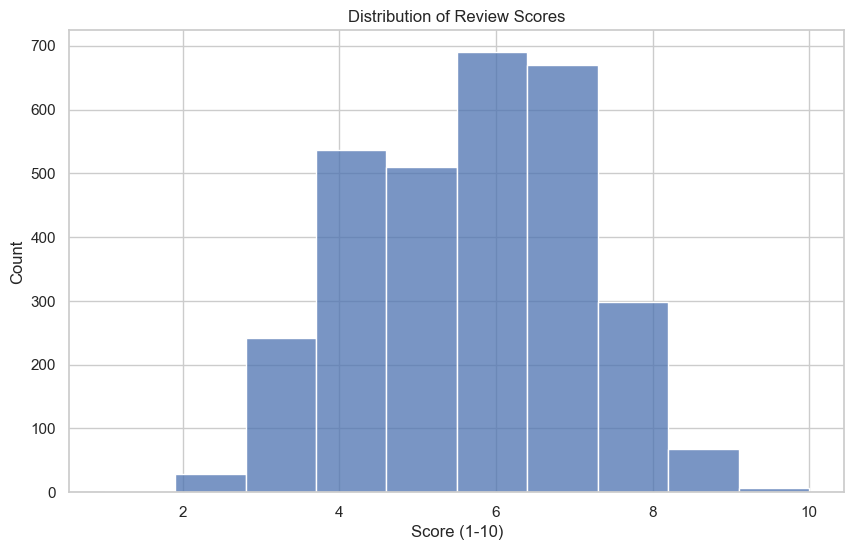

In [24]:
# Check score distribution and missing values
print(f"Missing scores: {final_dataset['score'].isna().sum()}")
print(f"Score distribution:\n{final_dataset['score'].value_counts().sort_index()}")

plt.figure(figsize=(10, 6))
sns.histplot(final_dataset['score'].dropna(), bins=10)
plt.title('Distribution of Review Scores')
plt.xlabel('Score (1-10)')
plt.ylabel('Count')
plt.show()

Correlation between acceptance and score: 0.6645


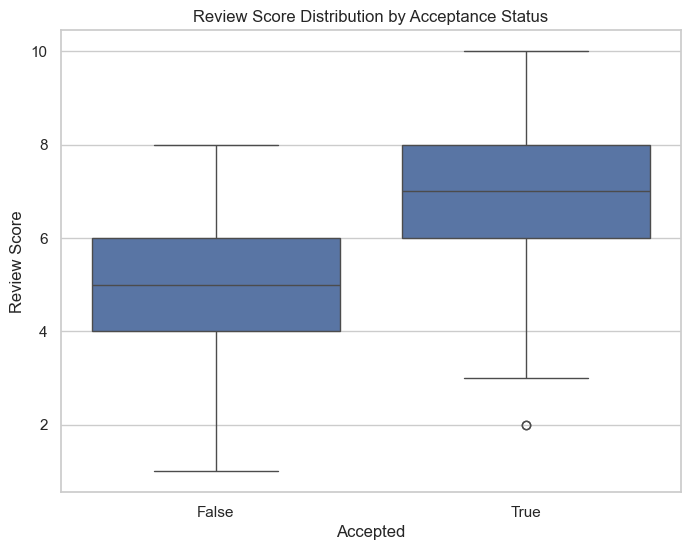

In [25]:
# Convert accepted to numeric (0/1) for correlation calculation
final_dataset['accepted_numeric'] = final_dataset['accepted'].astype(int)

# Calculate correlation
correlation = final_dataset['accepted_numeric'].corr(final_dataset['score'])
print(f"Correlation between acceptance and score: {correlation:.4f}")

# Visualize the relationship
plt.figure(figsize=(8, 6))
sns.boxplot(x='accepted', y='score', data=final_dataset)
plt.title('Review Score Distribution by Acceptance Status')
plt.xlabel('Accepted')
plt.ylabel('Review Score')
plt.show()

## 4. Data Preparation for Fine-tuning
Format the data into the chat template required by Unsloth/Qwen and split into Train/Val/Test sets.

In [27]:
import os

def format_for_unsloth(row):
    # Construct the conversation format expected by chat models
    system_prompt = "You are an expert academic reviewer. Analyze the provided research paper text. Provide a detailed and constructive review covering the paper's strengths and weaknesses. Conclude your review with a final numerical score on a scale of 1 to 10, formatted as 'Score: <score>'."
    
    # Truncate paper text if necessary, though Qwen has a large context window. 
    # For now, we use the full text.
    user_content = f"{row['paper_text']}"
    
    # Format the output
    assistant_content = f"{row['review']}\n\nScore: {row['score']}"
    
    return {
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_content},
            {"role": "assistant", "content": assistant_content}
        ]
    }

# Convert dataframe to list of dicts
formatted_data = final_dataset.apply(format_for_unsloth, axis=1).tolist()

# Split into train/val/test (80/10/10 split)
train_data, temp_data = train_test_split(formatted_data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Save to JSONL files
def save_to_jsonl(data, filename):
    with open(filename, 'w') as f:
        for entry in data:
            json.dump(entry, f)
            f.write('\n')
save_dir = 'finetune_dataset'
os.makedirs(save_dir, exist_ok=True)

save_to_jsonl(train_data, f'{save_dir}/unsloth_finetune_train.jsonl')
save_to_jsonl(val_data, f'{save_dir}/unsloth_finetune_val.jsonl')
save_to_jsonl(test_data, f'{save_dir}/unsloth_finetune_test.jsonl')

# Display a sample
print("\nSample entry:")
print(json.dumps(train_data[1], indent=2))


Sample entry:
{
  "messages": [
    {
      "role": "system",
      "content": "You are an expert academic reviewer. Analyze the provided research paper text. Provide a detailed and constructive review covering the paper's strengths and weaknesses. Conclude your review with a final numerical score on a scale of 1 to 10, formatted as 'Score: <score>'."
    },
    {
      "role": "user",
      "content": "Abstract: Natural image modeling is a landmark challenge of unsupervised learning. Variational Autoencoders (VAEs) learn a useful latent representation and model global structure well but have difficulty capturing small details. PixelCNN models details very well, but lacks a latent code and is difficult to scale for capturing large structures. We present PixelVAE, a VAE model with an autoregressive decoder based on PixelCNN. Our model requires very few expensive autoregressive layers compared to PixelCNN and learns latent codes that are more compressed than a standard VAE while still c